## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from utils.data.annotations import *
from utils.data.density_maps import create_and_save_density_maps
from utils.data.data_ops import move_val_split_to_train
from utils.input_output.io import save_np_arrays, load_np_arrays, load_images
from utils.input_output.io import save_gt_counts, load_gt_counts
from utils.preprocessing.misc import gaussian_smoothing

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Datasets

### 2.1 VGG Cells Dataset

In [4]:
DATASET_PATH = '../datasets/vgg_cells'
TRAIN_PATH = f'{DATASET_PATH}/train'
TRAIN_IMG_PATH = f'{TRAIN_PATH}/images'
TRAIN_GT_DOTS_PATH = f'{TRAIN_PATH}/gt_dots'
TRAIN_GT_COUNTS_PATH = f'{TRAIN_PATH}/gt_counts'
TRAIN_GT_DENSITY_MAPS_PATH = f'{TRAIN_PATH}/gt_density_maps'

VAL_PATH = f'{DATASET_PATH}/val'

TEST_PATH = f'{DATASET_PATH}/test'
TEST_IMG_PATH = f'{TEST_PATH}/images'
TEST_GT_DOTS_PATH = f'{TEST_PATH}/gt_dots'
TEST_GT_COUNTS_PATH = f'{TEST_PATH}/gt_counts'
TEST_GT_DENSITY_MAPS_PATH = f'{TEST_PATH}/gt_density_maps'

NUM_IMAGES = 100

In [5]:
move_val_split_to_train(VAL_PATH, TRAIN_PATH)

In [6]:
print(DATASET_PATH)
print(os.listdir(DATASET_PATH))

../datasets/vgg_cells
['test', 'train']


In [7]:
print(TRAIN_PATH)
print(os.listdir(TRAIN_PATH))

../datasets/vgg_cells/train
['gt_counts', 'gt_density_maps', 'gt_density_maps_aug', 'gt_dots', 'images', 'images_aug']


In [8]:
train_img_names = sorted(os.listdir(TRAIN_IMG_PATH))
train_dots_names = sorted(os.listdir(TRAIN_GT_DOTS_PATH))
test_img_names = sorted(os.listdir(TEST_IMG_PATH))
test_dots_names = sorted(os.listdir(TEST_GT_DOTS_PATH))

print(f'train split: {len(train_img_names)} images')
print(train_img_names[:3])
print(train_dots_names[:3])

print(f'\ntest split: {len(test_img_names)} images')
print(test_img_names[:3])
print(test_dots_names[:3])

train split: 100 images
['001cell.png', '002cell.png', '003cell.png']
['001dots.png', '002dots.png', '003dots.png']

test split: 100 images
['101cell.png', '102cell.png', '103cell.png']
['101dots.png', '102dots.png', '103dots.png']


In [9]:
train_dots_names = sorted(os.listdir(TRAIN_GT_DOTS_PATH))
test_dots_names = sorted(os.listdir(TEST_GT_DOTS_PATH))

print(TRAIN_GT_DOTS_PATH)
print(train_dots_names[:5])

print(TEST_GT_DOTS_PATH)
print(test_dots_names[:5])

../datasets/vgg_cells/train/gt_dots
['001dots.png', '002dots.png', '003dots.png', '004dots.png', '005dots.png']
../datasets/vgg_cells/test/gt_dots
['101dots.png', '102dots.png', '103dots.png', '104dots.png', '105dots.png']


#### Load dots images (.png)

In [10]:
train_dots_images = load_dots_images(TRAIN_GT_DOTS_PATH, train_dots_names)
test_dots_images = load_dots_images(TEST_GT_DOTS_PATH, test_dots_names)

print(len(train_dots_images), train_dots_images[0].shape, train_dots_images[0].dtype,
      train_dots_images[0].min(), train_dots_images[0].max(), train_dots_images[0].sum())

100 (256, 256) float64 0.0 1.0 135.0


#### Load some train images and density maps

In [11]:
train_images = load_images(TRAIN_IMG_PATH, train_img_names, num_images=NUM_IMAGES)
print(len(train_images))
print(train_images[0].dtype)

100
float64


In [12]:
train_gt_density_maps = load_np_arrays(TRAIN_GT_DENSITY_MAPS_PATH, num=NUM_IMAGES)
print(len(train_gt_density_maps))
print(train_gt_density_maps.dtype)

100
float64


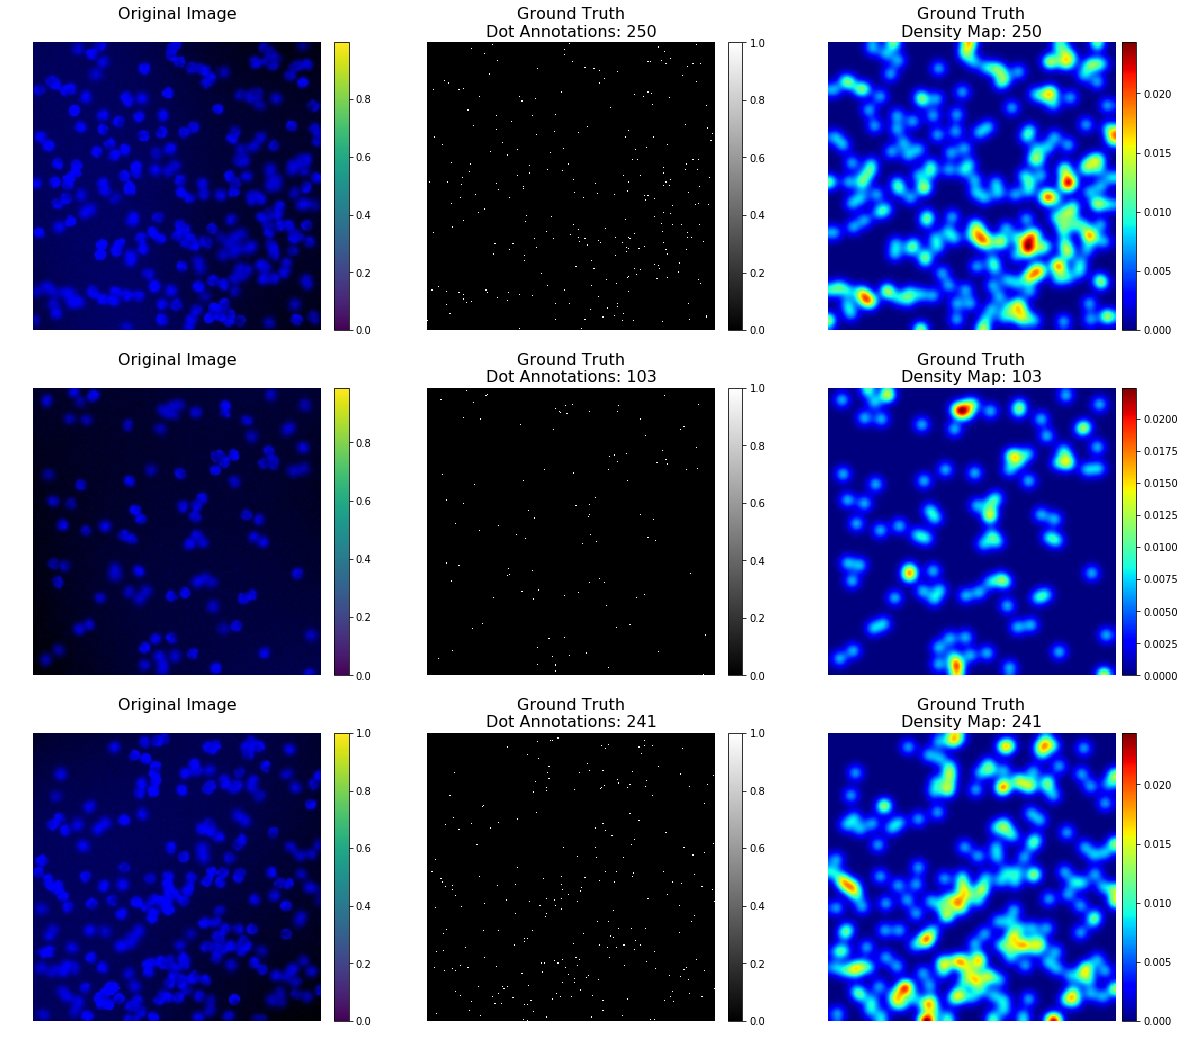

In [20]:
IMG_IDX = 57
ROWS = 3
NUM_PLOTS = 3
fontsize=16
plt.figure(figsize=(20, 18))

for i in range(ROWS):
    count = train_dots_images[i + IMG_IDX].sum().astype(np.int)
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 1)
    plt.title(f'Original Image\n', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_images[i + IMG_IDX])
    plt.colorbar(fraction=0.045, pad=0.04)
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 2)
    plt.title(f'Ground Truth\nDot Annotations: {count}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_dots_images[i + IMG_IDX], cmap='gray', interpolation='none')
    plt.colorbar(fraction=0.045, pad=0.04)
    #plt.imshow(skimage.morphology.binary_dilation(train_dots_images[i]), cmap='gray', interpolation='none')
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 3)
    plt.title(f'Ground Truth\nDensity Map: {train_gt_density_maps[i + IMG_IDX].sum():.0f}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_gt_density_maps[i + IMG_IDX], cmap='jet')
    plt.colorbar(fraction=0.045, pad=0.02)

In [ ]:
ROWS = 7
NUM_PLOTS = 3
fontsize=16
plt.figure(figsize=(20, 40))

for i in range(ROWS):
    count = train_dots_images[i].sum().astype(np.int)
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 1)
    plt.title(f'Original Image\n', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_images[i])
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 2)
    plt.title(f'Ground Truth\nDot Annotations: {count}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_dots_images[i], cmap='gray', interpolation='none')
    
    density_map = gaussian_smoothing([train_dots_images[i]], sigma=4)[0]
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 3)
    plt.title(f'Ground Truth\nDensity Map: {density_map.sum():.0f}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(density_map, cmap='jet')
    #plt.colorbar(fraction=0.045, pad=0.04)

In [ ]:
ROWS = 7
NUM_PLOTS = 3
fontsize=16
plt.figure(figsize=(20, 40))
row1, row2 = 0, 128
col1, col2 = 0, 128

for i in range(ROWS):
    count = train_dots_images[i][row1:row2, col1:col2].sum().astype(np.int)
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 1)
    plt.title(f'Original Image\n', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_images[i][row1:row2, col1:col2])
    
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 2)
    plt.title(f'Ground Truth\nDot Annotations: {count}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(train_dots_images[i][row1:row2, col1:col2], cmap='gray', interpolation='none')
    
    density_map = gaussian_smoothing([train_dots_images[i][row1:row2, col1:col2]], sigma=4)[0]
    plt.subplot(ROWS, NUM_PLOTS, NUM_PLOTS * i + 3)
    plt.title(f'Ground Truth\nDensity Map: {density_map.sum():.0f}', fontsize=fontsize)
    plt.axis('off')
    plt.imshow(density_map, cmap='jet')
    #plt.colorbar(fraction=0.045, pad=0.04)